# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1) Business Understanding

> 1. What is the majority gender of the customers and  what’s their average income ?
> 2. What is the correlation between the age and the average income?
> 3. what is the correlation between (gender and age), and (gender and income) ?
> 4. Would we be able to classify customers based on their income ?

Get an overview overview of the Starbucks population
What is the gender distribution?
What is the income distribution?
When do people typically become a member?
What is the average purchase distribution?
How do people react to different promotions?
Do people react to different promotions differently?
Does the reward of the promotion make people react differently?
Does it make sense to offer certain rewards?
Would starbucks save money overall if they offer a certain reward?
How well does a machine learning algorithm cluster the groups of users together?
How many number of clusters should Starbucks use
2 Clusters? (BOGO and Discount customers?)


Combine transaction, demographic and offer data to analyze which demographic groups respond(i.e.view&complete) best to which offer type;
Build a supervised learning model(specifically, a classification model) that predicts whether or not someone will respond to an offer

# 2)  Data Understanding

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [4]:
portfolio.channels

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [5]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
profile.became_member_on.value_counts()

20171207    43
20170819    42
20171007    40
20171113    39
20170928    38
20180125    38
20170815    38
20171010    37
20171121    36
20180120    35
20170728    35
20171217    35
20180501    35
20171204    35
20171017    34
20171201    34
20170806    34
20171212    34
20170802    34
20171208    34
20170921    34
20170926    34
20171027    34
20171023    34
20170910    34
20170901    34
20171126    33
20180109    33
20170731    33
20170822    33
            ..
20140803     1
20131108     1
20140718     1
20140311     1
20141213     1
20150317     1
20140113     1
20140804     1
20140215     1
20150207     1
20140226     1
20140702     1
20150127     1
20130731     1
20150111     1
20141101     1
20140306     1
20141006     1
20130923     1
20130801     1
20150402     1
20140723     1
20141214     1
20131009     1
20150503     1
20150519     1
20131121     1
20131201     1
20150102     1
20140921     1
Name: became_member_on, Length: 1716, dtype: int64

In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [9]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [11]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [12]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [13]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [14]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [15]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [16]:
# check NaNs
profile.isna().sum(axis=0)

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [17]:
# check null value
profile[profile['income'].isnull()].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [18]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [19]:
#check duplications
profile.duplicated().sum()

0

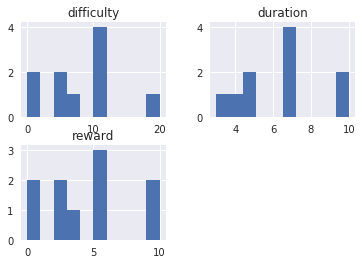

In [20]:
portfolio.hist();

In [21]:
profile.age

0        118
1         55
2        118
3         75
4        118
5         68
6        118
7        118
8         65
9        118
10       118
11       118
12        58
13        61
14        26
15        62
16        49
17       118
18        57
19        61
20        40
21        64
22        78
23       118
24        42
25        56
26       118
27        33
28        46
29        59
        ... 
16970     67
16971     52
16972     44
16973     30
16974     59
16975     61
16976     39
16977    118
16978     29
16979     63
16980    118
16981     84
16982    118
16983     72
16984     75
16985     26
16986     59
16987     57
16988     64
16989    118
16990     70
16991    118
16992     21
16993     60
16994    118
16995     45
16996     61
16997     49
16998     83
16999     62
Name: age, Length: 17000, dtype: int64

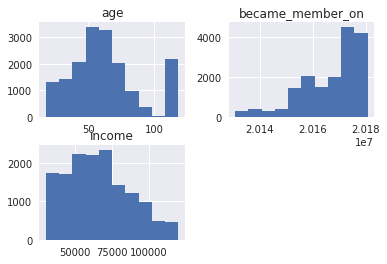

In [22]:
profile.hist();

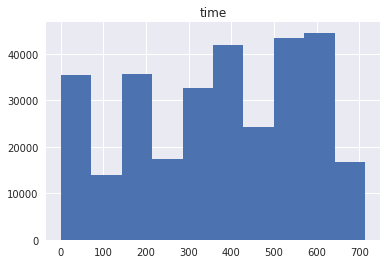

In [23]:
transcript.hist();

# 3) Data Preparation and Cleaning

## portfolio DataFram Cleaning process
 - Change 'id' column to 'OfferID'
 - One hot encode 'offer_type' column 
 - One hot encode 'channels' columns
 
 



## Profile Dataframe Cleaning process
- remove age outlier 118
- Removed customers with missing income data
- Removed customer profiles where the gender data is missing
- One hot encode 'gender' column for analysis.
- Change the column 'id ' to 'CustomerID'.
- fix the type of 'became_member_on' column to datetime object
- split' became_member_on' to  year,  Month ,Day and Date 

## Ttranscript Dataframe Cleaning process
 - Split 'value' column in 2 saperate coloumns the'value' and 'value_type' coloumns
 - change 'time' to integer amount
 - Change the column 'person' to 'CustomerID'.
 - Remove 'CustomerID' that are not in the profile DataFrame
 - SPLIT ' events' to  year, start Month and age range
 - One hot encode 'event' coloumns to 'offer_received',offer_viewed and 'offer_completed'



## portfolio DataFram Cleaning process (code)

In [24]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [25]:
# Change 'id' column to 'OfferID'
portfolio.rename(columns={'id': 'OfferID',},inplace=True)

In [26]:
 # apply one hot encoding to offer_type column
offer_type = pd.get_dummies(portfolio['offer_type'])


In [27]:
# combine the portfolio and offer_type dataframe to form a cleaned dataframe
portfolio = pd.concat([portfolio, offer_type], axis=1, sort=False)

In [28]:
#drop offer_type column
portfolio.drop(columns='offer_type' , inplace=True)

In [29]:
portfolio

,channels,difficulty,duration,OfferID,reward,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,0,1,0
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,0,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,0,0
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,2,0,1,0


In [30]:
#One hot encode 'channels' columns
# apply one hot encoding to channels column [web, email, mobile, social]
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)

# drop the channels and offer_type column
portfolio.drop(['channels'], axis=1, inplace=True)

In [31]:
portfolio

,difficulty,duration,OfferID,reward,bogo,discount,informational,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,0,1,0,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,0,1,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,0,0,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,0,1,0,1,1,1,0


## Profile Dataframe Cleaning process (code)

In [32]:
# remove age outlier age 118 
remove = profile[profile.age == 118]
profile = profile[profile.age < 118].reset_index(drop=True)
# store 0 and 1s in new columns
profile['missing'] = profile['age'].apply(lambda value: 1 if pd.isna(value) else 0)
dropped = profile[profile['missing'] == 1].index
# cleaned Dataset
profile = profile.drop(dropped)

In [33]:
profile.age.head()

0    55
1    75
2    68
3    65
4    58
Name: age, dtype: int64

In [34]:
#Removed customers with missing income data
#Removed customer profiles where the gender data is missing
profile = profile[profile['income'].notnull()]
profile = profile[profile['gender'] != 'O']
profile = profile.reset_index(drop=True)

In [35]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14613 entries, 0 to 14612
Data columns (total 6 columns):
age                 14613 non-null int64
became_member_on    14613 non-null int64
gender              14613 non-null object
id                  14613 non-null object
income              14613 non-null float64
missing             14613 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 685.1+ KB


In [36]:
profile.gender.value_counts()

M    8484
F    6129
Name: gender, dtype: int64

In [37]:
#Change the column 'id ' to 'CustomerID'.
profile=profile.rename(columns={'id': 'CustomerID'})
profile.head()

,age,became_member_on,gender,CustomerID,income,missing
0,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0
1,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
2,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,0
3,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,0
4,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0


In [38]:
#fix the type of 'became_member_on' column to datetime object
#split' became_member_on' to  year,  Month ,Day and Date 
profile['M-Year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
profile['M_Month'] = profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
profile['M_Day'] = profile.became_member_on.apply(lambda x: int(str(x)[6:]))
profile['M_Date'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
profile.drop('became_member_on', axis = 1, inplace = True)

In [39]:
profile.head()

,age,gender,CustomerID,income,missing,M-Year,M_Month,M_Day,M_Date
0,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,2017,7,15,2017-07-15
1,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,2017,5,9,2017-05-09
2,68,M,e2127556f4f64592b11af22de27a7932,70000.0,0,2018,4,26,2018-04-26
3,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,2018,2,9,2018-02-09
4,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,2017,11,11,2017-11-11


## Ttranscript Dataframe Cleaning process(code)
 - Split 'value' column in 2 saperate coloumns the'value' and 'value_type' coloumns
 - Change the column 'person' to 'CustomerID'.
 - Change the column 'time' from hours to days.
 - Remove 'CustomerID' that are not in the profile DataFrame
 - SPLIT ' events' to  year, start Month and age range
 - One hot encode 'event' coloumns to 'offer_received',offer_viewed and 'offer_completed'

In [40]:
#Split 'value' column in 2 saperate coloumns the'value' and 'value_type' coloumns
transcript['value_type'] = transcript['value'].apply(lambda x: list(x.keys())[0]) # First value is the value_type
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0]) # Second value is the new value
transcript.head()

,event,person,time,value,value_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer id
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer id
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,offer id
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,offer id
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,offer id


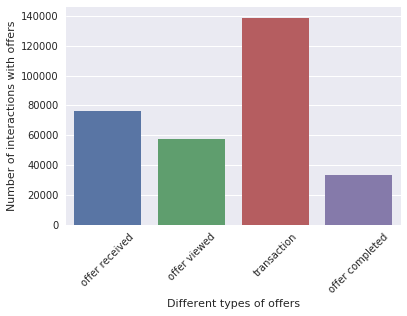

In [41]:
sns.countplot(x='event', data=transcript)
plt.ylabel('Number of interactions with offers')
plt.xlabel('Different types of offers')
plt.xticks(rotation = 45)
plt.show();

### Most of the offers were started as a transaction by customers.

In [42]:
# change time to integer amount
transcript.astype({'time': 'int32'}).dtypes
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 5 columns):
event         306534 non-null object
person        306534 non-null object
time          306534 non-null int64
value         306534 non-null object
value_type    306534 non-null object
dtypes: int64(1), object(4)
memory usage: 11.7+ MB


In [43]:
#Change the column 'person' to 'CustomerID'
transcript =transcript.rename(columns={'person': 'CustomerID'}).head()

In [44]:
#Remove 'CustomerID' that are not in the profile DataFrame
# Remove customer id's that are not in the customer profile DataFrame
select_data=transcript['CustomerID'].isin(profile['CustomerID'])
transcript = transcript[select_data ]

# 4 ) Data Modeling and Analysis

## Income by gender for each Month

In [45]:

profile_Female = profile.copy()
profile_Female = profile_Female[profile_Female['gender'] == 'F']
profile_Female.head()

,age,gender,CustomerID,income,missing,M-Year,M_Month,M_Day,M_Date
0,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,2017,7,15,2017-07-15
1,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,2017,5,9,2017-05-09
5,61,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,0,2017,9,11,2017-09-11
7,62,F,31dda685af34476cad5bc968bdb01c53,71000.0,0,2016,2,11,2016-02-11
10,61,F,a448667f336b42c9a66fc5ffd5d73772,40000.0,0,2018,5,1,2018-05-01


In [46]:
profile.head()

,age,gender,CustomerID,income,missing,M-Year,M_Month,M_Day,M_Date
0,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,2017,7,15,2017-07-15
1,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,2017,5,9,2017-05-09
2,68,M,e2127556f4f64592b11af22de27a7932,70000.0,0,2018,4,26,2018-04-26
3,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,2018,2,9,2018-02-09
4,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,2017,11,11,2017-11-11


In [47]:

profile_Male = profile.copy()
profile_Male = profile_Male[profile_Male['gender'] == 'M']
profile_Male.head()

,age,gender,CustomerID,income,missing,M-Year,M_Month,M_Day,M_Date
2,68,M,e2127556f4f64592b11af22de27a7932,70000.0,0,2018,4,26,2018-04-26
3,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,2018,2,9,2018-02-09
4,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,2017,11,11,2017-11-11
6,26,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,0,2014,2,13,2014-02-13
8,49,M,62cf5e10845442329191fc246e7bcea3,52000.0,0,2014,11,13,2014-11-13


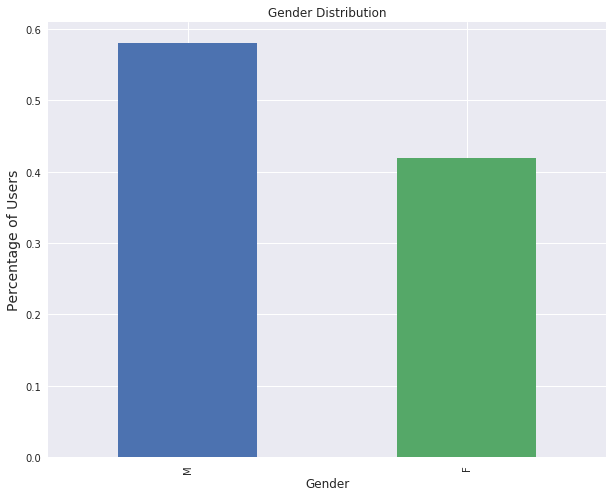

In [48]:
profile.gender.value_counts(normalize=True).plot('bar', figsize = (10,8))
plt.title('Gender Distribution')
plt.ylabel('Percentage of Users', fontsize = 14)
plt.xlabel('Gender', fontsize = 12);

In [49]:
mean_val = profile.income.mean() # 65404.99
profile['income'].fillna(mean_val, inplace = True)

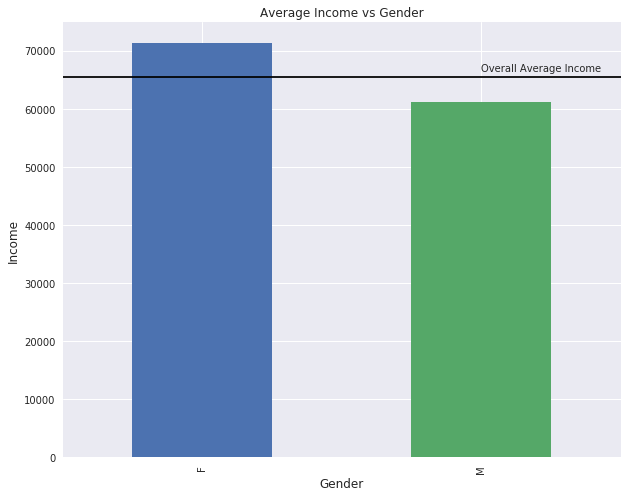

In [50]:
gender_income = profile.groupby('gender', as_index=False).agg({'income':'mean'})
gender_income.plot(kind = 'bar', x = 'gender', y = 'income', legend=False, figsize=(10,8))
plt.hlines(mean_val, -100 , 1000)
plt.ylabel('Income', fontsize = 12)
plt.xlabel('Gender', fontsize = 12)
plt.title('Average Income vs Gender')
plt.text(1, mean_val + 1000, 'Overall Average Income');

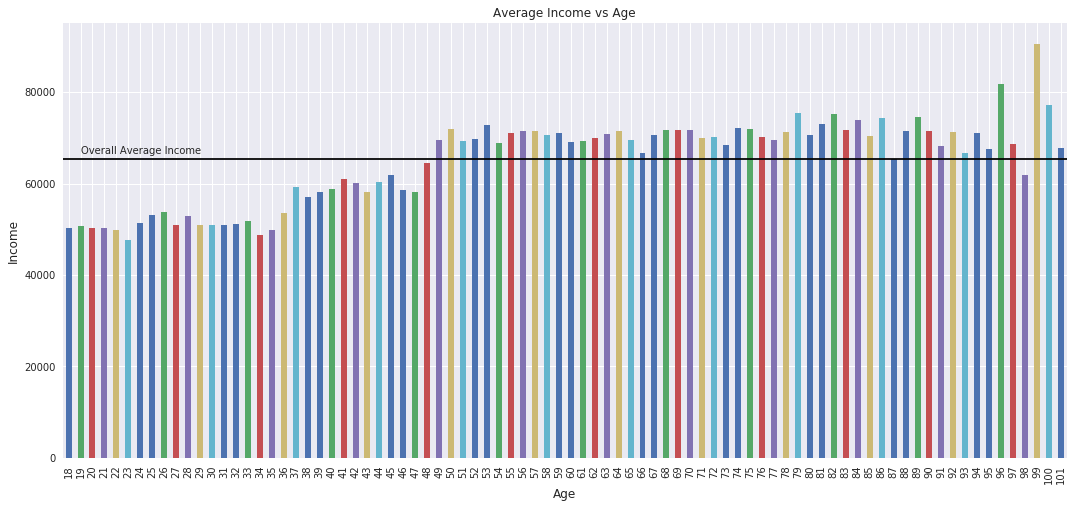

In [51]:
age_income = profile.groupby('age', as_index=False).agg({'income':'mean'})
age_income.plot(kind = 'bar', x = 'age', y = 'income', legend=False, figsize=(18,8))
plt.hlines(mean_val, -100 , 1000)
plt.ylabel('Income', fontsize = 12)
plt.xlabel('Age', fontsize = 12)
plt.title('Average Income vs Age')
plt.text(1, mean_val + 1000, 'Overall Average Income');

In [52]:
profile.head()

,age,gender,CustomerID,income,missing,M-Year,M_Month,M_Day,M_Date
0,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,2017,7,15,2017-07-15
1,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,2017,5,9,2017-05-09
2,68,M,e2127556f4f64592b11af22de27a7932,70000.0,0,2018,4,26,2018-04-26
3,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,2018,2,9,2018-02-09
4,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,2017,11,11,2017-11-11


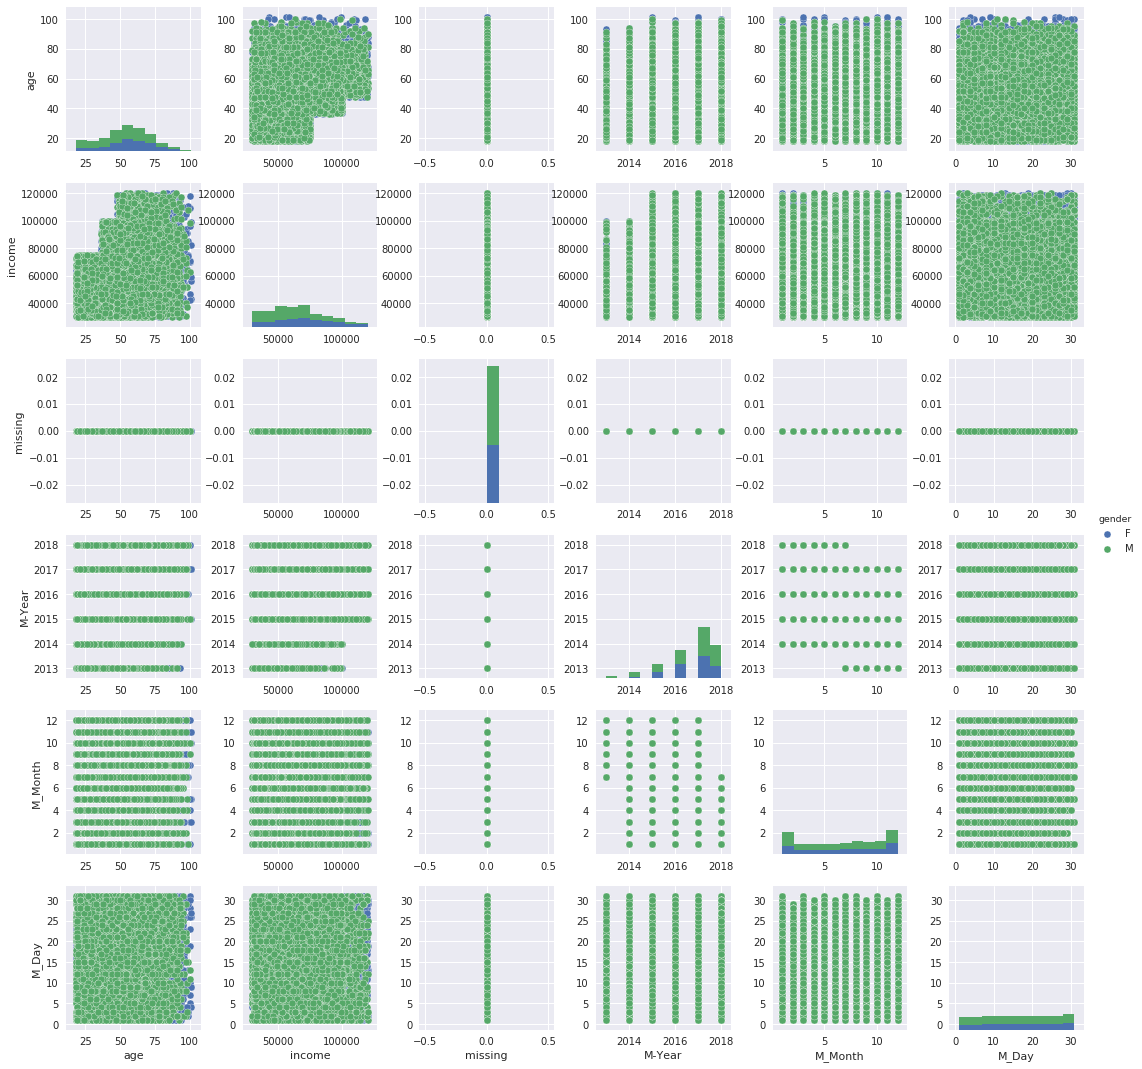

In [53]:
sns.pairplot(profile, hue="gender");

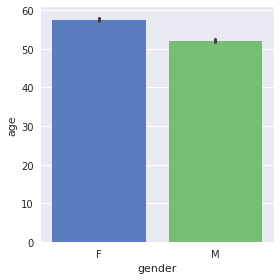

In [54]:
sns.factorplot("gender","age" ,data=profile, kind="bar", palette="muted", legend=True);

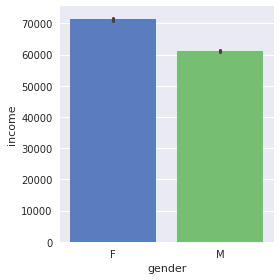

In [55]:
sns.factorplot("gender", "income",data=profile, kind="bar", palette="muted", legend=True);

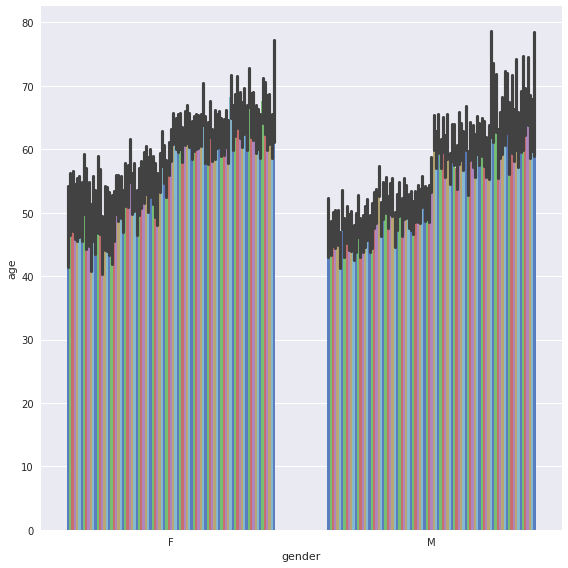

In [56]:
sns.factorplot("gender","age" , "income",data=profile, kind="bar", palette="muted", legend=False, size=8);

In [57]:
portfolio

,difficulty,duration,OfferID,reward,bogo,discount,informational,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,0,1,0,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,0,1,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,0,0,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,0,1,0,1,1,1,0


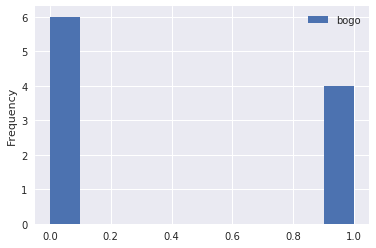

In [58]:
portfolio.plot(kind = 'hist', x = 'duration', y = 'bogo', legend = True);

### Preparing data for modeling

In [59]:
profile.head()

,age,gender,CustomerID,income,missing,M-Year,M_Month,M_Day,M_Date
0,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,2017,7,15,2017-07-15
1,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,2017,5,9,2017-05-09
2,68,M,e2127556f4f64592b11af22de27a7932,70000.0,0,2018,4,26,2018-04-26
3,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,2018,2,9,2018-02-09
4,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,2017,11,11,2017-11-11


In [60]:
transcript.head()

,event,CustomerID,time,value,value_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer id
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,offer id


In [61]:
portfolio.head()

,difficulty,duration,OfferID,reward,bogo,discount,informational,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,1,0,0


In [62]:
merge = pd.merge(left = transcript, right = profile, on = 'CustomerID')

In [63]:
merge

,event,CustomerID,time,value,value_type,age,gender,income,missing,M-Year,M_Month,M_Day,M_Date
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer id,75,F,100000.0,0,2017,5,9,2017-05-09
1,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,offer id,68,M,70000.0,0,2018,4,26,2018-04-26


In [64]:
# Replacing the categorical values of the features by its corresponding numerical values

labels_event1 = merge['event'].astype('category').cat.categories.tolist()
replace_map_comp_event1 = {'event' : {k: v for k,v in zip(labels_event1,list(range(1,len(labels_event1)+1)))}}

labels_offer_type1 = merge['value_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type1 = {'value_type' : {k: v for k,v in zip(labels_offer_type1,list(range(1,len(labels_offer_type1)+1)))}}

merge.replace(replace_map_comp_event1, inplace=True)
merge.replace(replace_map_comp_offer_type1, inplace=True)

In [65]:
# One hot encode 'gender' column for analysis. 1 for Male, 2 for Female
recode = {'M': 1, 'F': 2}
merge.replace({'gender': recode}, inplace=True)

In [66]:
merge

,event,CustomerID,time,value,value_type,age,gender,income,missing,M-Year,M_Month,M_Day,M_Date
0,1,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,75,2,100000.0,0,2017,5,9,2017-05-09
1,1,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,1,68,1,70000.0,0,2018,4,26,2018-04-26


In [67]:
# Split the data into features and target label
X = merge[['M-Year','value_type','event','age','gender']]
Y = merge['income']

In [68]:
# normalizing some numerical values 
scaler = MinMaxScaler()
features = ['M-Year', 'value_type', 'gender', 'age']
X_scaled = X.copy()
X_scaled[features] = scaler.fit_transform(X_scaled[features])
X_scaled.head()

,M-Year,value_type,event,age,gender
0,0.0,0.0,1,1.0,1.0
1,1.0,0.0,1,0.0,0.0


In [69]:
# creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [70]:
# defining a function to calculate the accuracy for the models we will try below 
def predict_score(model):
    pred = model.predict(X_test)
    
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    
    # Calculate mean absolute percentage error
    mean_APE = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mean_APE)
    
    return round(accuracy, 4)

### The chosen algorithms are: 

###### 1. Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.


###### 2. Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. Bayes’ theorem states the following relationship,

1. Decision Tree


In [77]:
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set: {round(dt.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(dt)}%')

Accuracy of Decision Tree classifier on training set: 100.0%.
Prediction Accuracy: 57.1429%


2. Naive Bayes

In [72]:
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
print(f'Accuracy of SVM classifier on training set: {round(gnb.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(gnb)}%')

Accuracy of SVM classifier on training set: 100.0%.
Prediction Accuracy: 57.1429%


/opt/conda/lib/python3.6/site-packages/sklearn/naive_bayes.py:432: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/opt/conda/lib/python3.6/site-packages/sklearn/naive_bayes.py:434: RuntimeWarning: invalid value encountered in true_divide
  (self.sigma_[i, :]), 1)
/opt/conda/lib/python3.6/site-packages/sklearn/naive_bayes.py:434: RuntimeWarning: divide by zero encountered in true_divide
  (self.sigma_[i, :]), 1)


### Tuning the models

In [79]:
# Decision Tree
dt = DecisionTreeClassifier(criterion="entropy", max_depth=3,splitter = "random", random_state=0)

dt.fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set: {round(dt.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(dt)}%')

Accuracy of Decision Tree classifier on training set: 100.0%.
Prediction Accuracy: 57.1429%


In [90]:
# Naive Bayes
gnb = GaussianNB(priors=[1]) 
gnb.fit(X_train, y_train) 
print(f'Accuracy of SVM classifier on training set: {round(gnb.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(gnb)}%')

Accuracy of SVM classifier on training set: 100.0%.
Prediction Accuracy: 57.1429%


/opt/conda/lib/python3.6/site-packages/sklearn/naive_bayes.py:432: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/opt/conda/lib/python3.6/site-packages/sklearn/naive_bayes.py:434: RuntimeWarning: invalid value encountered in true_divide
  (self.sigma_[i, :]), 1)
/opt/conda/lib/python3.6/site-packages/sklearn/naive_bayes.py:434: RuntimeWarning: divide by zero encountered in true_divide
  (self.sigma_[i, :]), 1)


##### Tuning parameters gives in same result

### Conclusion :

#### Findings:
1. Among the different transcript events, the offers were altered into transactions, however less than 25% of those completed the offer.
 
2. Most of the users are males
 
3. The overall average income is higher in female than male.
 
4. Customers 49 years old and older gain more that the overall average income.
 
5. The year 2018 had more registered customers in compare to 2014-2016
 
6. The age of the registered female customers is higher than the male customers.
 
7.  I have tried 2 machine learning algorithms; Decision Tree and Naive Bayes, both had 57% accuracy rate.


### Improvments :

> In future, I would analyze using larger dataset.

### Final thoghts :

This capstone project has helped me putting together the data science skills I have learned during the nano degree, and show me how far I have became and learned.
All thanks to Udacity team, reviwers and mentors whom whithout I wouldn't learn that much.

## Refrence:
> https://github.com/anchorP34/Starbucks-Customer-Clusters/blob/master/Starbucks%20Capstone%20Project%20(1).ipynb
> https://github.com/Najlaa-Shariefi/Starbucks-Capstone-Project-DSND/blob/master/Starbucks_Capstone_notebook.ipynb
> https://github.com/hamadalaqeel/Starbuck-s-Capstone-Project/blob/master/Starbucks_Capstone_notebook.ipynb
> https://scikit-learn.org/stable/modules/tree.html
>https://scikit-learn.org/stable/modules/naive_bayes.html